# Learning Curves


We aim to find out how strong every model is affected by additional training examples. We base our insights on a similar approach to: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

__Hypothesis:__ We would expect to see a stronger overall performance in F1-Scores of Transformers based models, but also stronger increases in performance (F1-Scores) for every sample added. Samples are added by percentage of overall training data.

We perform a 0.33 split between training and testdata


## Load Results

In [1]:
import os
from tiltify.config import Path
from glob import glob
import json

iwpe_dir = os.path.join(Path.root_path, "experiments/IWPE/results_2")
results_per_model = {}
for results_path in glob(os.path.join(iwpe_dir, "*/results.json")):
    model_name = results_path.split("/")[-2]
    with open(results_path, "r") as f:
        results = json.load(f)
    results_per_model[model_name] = results


Environment Variables not found. Entering Test Mode!


**F1 Scores from True are only given, as documents without any rights will have recall of 1.**
**All logits and preds are also given, as one may calculate correlation or something similar**

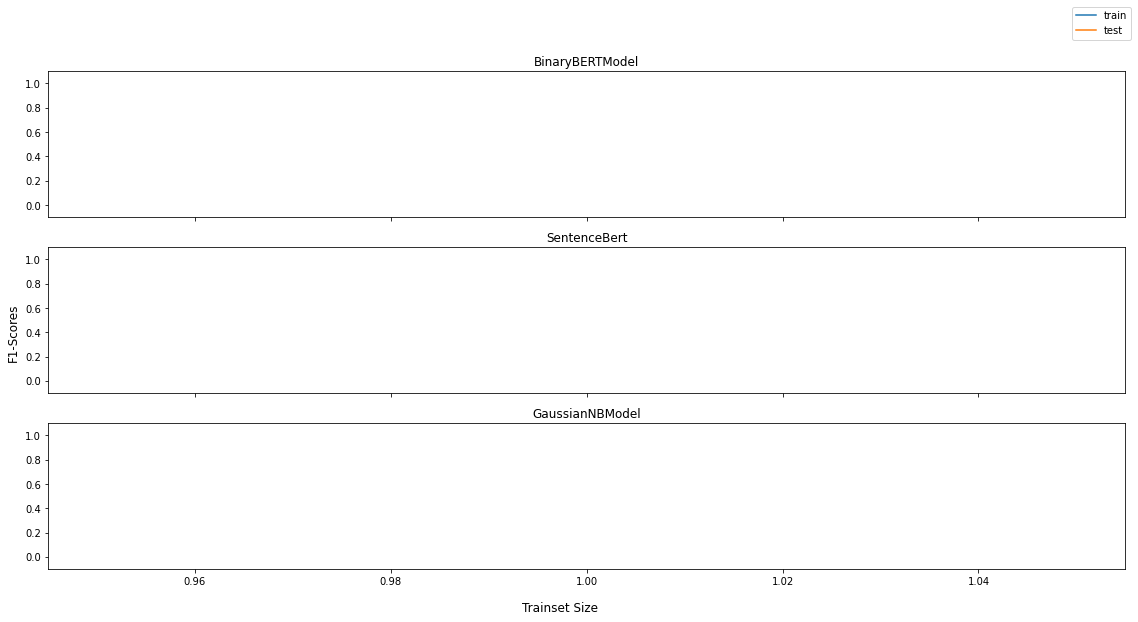

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import create_learning_df



fig, ax = plt.subplots(3, sharex="col", sharey="row")
fig.set_size_inches(16, 8)
i = 0
for model_name, results in results_per_model.items():

    learning_df = create_learning_df(results, type_of_results="5_k_rank_metrics")
    plot_idx = learning_df["train_size"]
    ax[i].set_ylim([-0.1, 1.1])
    sns.lineplot(data=learning_df, x=plot_idx, y="train_f1_scores", ax=ax[i])
    sns.lineplot(data=learning_df, x=plot_idx, y="test_f1_scores", ax=ax[i])
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    ax[i].fill_between(plot_idx, learning_df["min_train_f1_scores"], learning_df["max_train_f1_scores"], alpha=.2)
    ax[i].fill_between(plot_idx, learning_df["min_test_f1_scores"], learning_df["max_test_f1_scores"], alpha=.2)
    ax[i].set_title(model_name)
    i+=1

fig.supxlabel("Trainset Size")
fig.supylabel("F1-Scores")
# lines_labels = [single_ax.get_legend_handles_labels() for single_ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(["train", "test"], loc="lower right", bbox_to_anchor=(1,1), bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig(os.path.join(iwpe_dir, "learning_curves.png"))

In [3]:
import pandas as pd
import numpy as np

metrics = ["5_k_rank_metrics", "10_k_rank_metrics", "25_k_rank_metrics", "classify_metrics"]
columns_df = metrics + ["support"]
results_df = pd.DataFrame([], index=results_per_model.keys(), columns=columns_df)
for metrics_type in metrics:
    for model_name, results in results_per_model.items():
        learning_df = create_learning_df(results, type_of_results=metrics_type)
        test_f1_scores = learning_df["test_f1_scores"].tolist()[-1]
        min_scores = learning_df["min_test_f1_scores"].tolist()[-1]
        max_scores = learning_df["max_test_f1_scores"].tolist()[-1]
        std_scores = np.std(np.array([min_scores, max_scores]))
        results_df.loc[model_name, metrics_type] = f"{round(test_f1_scores, 2)} ({round(std_scores, 2)})"
        if metrics_type != "classify_metrics":
            results_df.loc[model_name, "support"] = int(learning_df["support"].tolist()[-1])
        else:
            pass
results_df = results_df.T
results_df.head()
results_df.to_latex(os.path.join(iwpe_dir, "results.tex"), index=True)
    

In [4]:
learning_df.head()

,train_size,train_f1_scores,test_f1_scores,support,max_train_f1_scores,max_test_f1_scores,max_support,min_train_f1_scores,min_test_f1_scores,min_support
0,1,0.375969,0.375729,5909.0,0.376069,0.375801,5909,0.37587,0.375657,5909
